In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col
from pyspark.ml.feature import Imputer

In [2]:
spark = SparkSession.builder \
    .appName("CrashRemedyPrediction") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.sql.debug.maxToStringFields", "200") \
    .getOrCreate()

25/04/05 22:04:14 WARN Utils: Your hostname, Glorias-MacBook-Air-10.local resolves to a loopback address: 127.0.0.1; using 10.0.0.117 instead (on interface en0)
25/04/05 22:04:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/05 22:04:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/05 22:04:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
merged_all_df = spark.read.parquet("data/parquet/final_real_df")
merged_all_df.printSchema()

root
 |-- lat_bin: double (nullable = true)
 |-- lon_bin: double (nullable = true)
 |-- time_period: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- region: string (nullable = true)
 |-- total_crashes: long (nullable = true)
 |-- crash_severity: string (nullable = true)
 |-- avg_severity_weight: double (nullable = true)
 |-- weather: string (nullable = true)
 |-- avg_speed_limit: double (nullable = true)
 |-- season: string (nullable = true)
 |-- road_condition: string (nullable = true)
 |-- road_surface: string (nullable = true)
 |-- avg_total_vehicles_involved: double (nullable = true)
 |-- avg_total_casualty: double (nullable = true)
 |-- pct_intersection_crash: double (nullable = true)
 |-- pct_pedestrian_involved: double (nullable = true)
 |-- pct_distraction_involved: double (nullable = true)
 |-- pct_drug_involved: double (nullable = true)
 |-- p

In [4]:
# Step 5: Compute crash quantiles to assign labels

# Compute a combined risk score
merged_all_df = merged_all_df.withColumn(
    "combined_risk_score",
    (col("total_crashes") * col("avg_severity_weight"))
)

quantiles = merged_all_df.approxQuantile("combined_risk_score", [0.5, 0.9], 0.01)
q50, q90 = quantiles

# Define risk levels based on combined score
merged_all_df = merged_all_df.withColumn(
    "hotspot_risk_level",
    when(
        (col("combined_risk_score") >= q90), "high"
    ).when(
        (col("combined_risk_score") >= q50) & (col("combined_risk_score") < q90), "moderate"
    ).when(
        (col("combined_risk_score") < q50), "low"
    ).otherwise("unknown")
)

#merged_all_df.select("crash_severity", "avg_severity_weight", "combined_risk_score", "hotspot_risk_level").show()
#merged_all_df.groupBy("hotspot_risk_level").count().show()

In [ ]:
from pyspark.sql import functions as F
#merged_all_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in merged_all_df.columns]).show()
'road_condition', 'last_weather', 'last_weather_description'

merged_all_df.select('weather').distinct().count().show()
merged_all_df.select('road_condition').distinct()..count().show()
merged_all_df.select('last_weather').distinct().show()
merged_all_df.select('last_weather_description').distinct().show()


+------------+
|     weather|
+------------+
|         fog|
|  snow/sleet|
|     raining|
|        hail|
|       other|
|       clear|
|     unknown|
|      cloudy|
| strong wind|
|smog / smoke|
+------------+

+--------------+
|road_condition|
+--------------+
|           dry|
|          snow|
|         slush|
|         other|
|           ice|
|       unknown|
|           wet|
|         muddy|
+--------------+

+------------+
|last_weather|
+------------+
|      Clouds|
|       Clear|
+------------+

+------------------------+
|last_weather_description|
+------------------------+
|        scattered clouds|
|              few clouds|
|               clear sky|
|           broken clouds|
+------------------------+



In [42]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when
from pyspark.ml.feature import OneHotEncoder

# Step 1: StringIndex all categorical columns (and the target)
categorical_columns = ['municipality', 'weather', 'season', 'road_condition', 'last_weather', 'last_weather_description']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='skip') for col in categorical_columns]

# Step 2: OneHotEncode all indexed categorical columns
encoder = OneHotEncoder(inputCols=[col + "_index" for col in categorical_columns], 
                        outputCols=[col + "_ohe" for col in categorical_columns])

# Step 3: StringIndex the target variable
indexer_target = StringIndexer(inputCol="hotspot_risk_level", outputCol="label", handleInvalid='skip')

# Step 4: Assemble all features into a single vector
numerical_columns = ['lat_bin', 'lon_bin', 'total_crashes', 'avg_severity_weight', 'avg_speed_limit', 'avg_total_vehicles_involved', 
                     'avg_total_casualty', 'pct_intersection_crash', 'pct_pedestrian_involved', 'pct_distraction_involved', 
                     'pct_drug_involved', 'pct_impaired_involved', 'pct_speed_involved', 'pct_is_weekend', 'pct_is_rush_hour', 
                     'avg_temp', 'avg_visibility', 'avg_clouds', 'max_rain', 'max_snow', 'avg_speed', 'avg_flow_speed', 
                     'avg_travel_time', 'avg_flow_travel_time', 'avg_speed_diff', 'had_closure']

feature_cols = numerical_columns + [col + "_ohe" for col in categorical_columns]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Step 5: Create the RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

# Step 6: Build the pipeline
pipeline = Pipeline(stages=indexers + [indexer_target, encoder, assembler, rf])

# Split data into training and test sets
train_df, test_df = merged_all_df.randomSplit([0.8, 0.2], seed=42)

# Step 7: Train the model
model = pipeline.fit(train_df)

# Step 8: Make predictions
predictions = model.transform(test_df)

# Step 9: Evaluate the model
# Create evaluators for Precision, Recall, and F1 Score
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Calculate accuracy, precision, recall, and F1 score
accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

pipeline.save("model/rfc_pipeline_model")

model.save("model/rfc_model")



Model Accuracy: 0.8668
Precision: 0.7818
Recall: 0.8668
F1 Score: 0.8194


/Users/gloriamo/Desktop/van-crash-predictor/venv/lib/python3.13/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
DenseMatrix([[2384.,   52.,    0.],
             [  63., 1996.,    0.],
             [   0.,  558.,    0.]])


/Users/gloriamo/Desktop/van-crash-predictor/venv/lib/python3.13/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


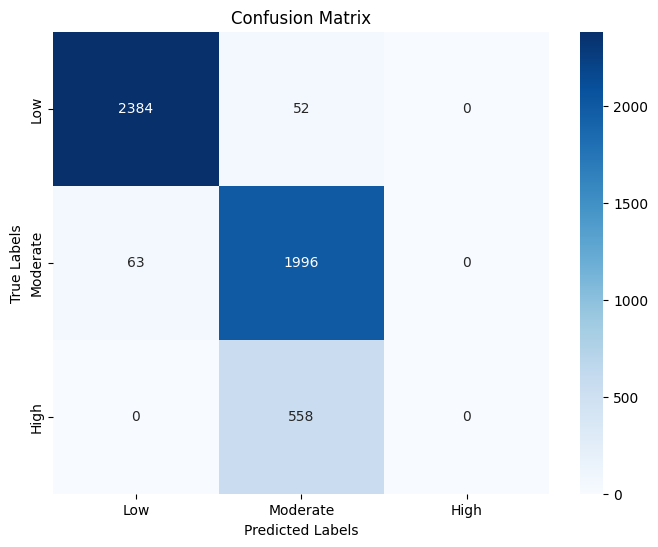

In [21]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Extract the prediction and label columns
prediction_and_labels = predictions.select("prediction", "label").rdd

# Create the confusion matrix
metrics = MulticlassMetrics(prediction_and_labels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix()
print("Confusion Matrix:")
print(confusion_matrix)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract the prediction and label columns
prediction_and_labels = predictions.select("prediction", "label").rdd

# Create the confusion matrix
metrics = MulticlassMetrics(prediction_and_labels)

# Get the confusion matrix as a DenseMatrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues", xticklabels=["Low", "Moderate", "High"], yticklabels=["Low", "Moderate", "High"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Get the trained random forest model
rf_model = model.stages[-1]

# Get feature importances
feature_importances = rf_model.featureImportances

# Display feature importance values
print("Feature Importance:")
for feature, importance in zip(numerical_columns + [col + "_index" for col in categorical_columns], feature_importances):
    print(f"{feature}: {importance}")


Feature Importance:
lat_bin: 0.009128312943010503
lon_bin: 0.008846757953254347
total_crashes: 0.32321102455449846
avg_severity_weight: 0.05582168715436501
avg_speed_limit: 0.018450195970431158
avg_total_vehicles_involved: 0.09780200181161089
avg_total_casualty: 0.03596306698237824
pct_intersection_crash: 6.872790156679514e-06
pct_pedestrian_involved: 5.697036609423417e-05
pct_distraction_involved: 0.029971183022346203
pct_drug_involved: 0.0786090850367026
pct_impaired_involved: 0.11982062683664596
pct_speed_involved: 0.13818648145519943
pct_is_weekend: 0.02591985901300493
pct_is_rush_hour: 0.016931580704010737
avg_temp: 0.0
avg_visibility: 0.0
avg_clouds: 6.504916875296852e-06
max_rain: 0.0
max_snow: 0.0
avg_speed: 0.0
avg_flow_speed: 0.0
avg_travel_time: 8.129724857543366e-06
avg_flow_travel_time: 3.369206007447676e-06
avg_speed_diff: 2.075217624603964e-06
had_closure: 0.0
municipality_index: 0.0009349709379103363
weather_index: 0.016074064031100666
season_index: 0.003627156502154870

Sorted Feature Importance:
total_crashes: 0.32321102455449846
pct_speed_involved: 0.13818648145519943
pct_impaired_involved: 0.11982062683664596
avg_total_vehicles_involved: 0.09780200181161089
pct_drug_involved: 0.0786090850367026
avg_severity_weight: 0.05582168715436501
avg_total_casualty: 0.03596306698237824
pct_distraction_involved: 0.029971183022346203
pct_is_weekend: 0.02591985901300493
avg_speed_limit: 0.018450195970431158
pct_is_rush_hour: 0.016931580704010737
weather_index: 0.016074064031100666
lat_bin: 0.009128312943010503
lon_bin: 0.008846757953254347
season_index: 0.0036271565021548705
municipality_index: 0.0009349709379103363
last_weather_index: 0.0007523252523051678
last_weather_description_index: 0.0004346451204244871
road_condition_index: 0.00016133193814835513
pct_pedestrian_involved: 5.697036609423417e-05
avg_travel_time: 8.129724857543366e-06
pct_intersection_crash: 6.872790156679514e-06
avg_clouds: 6.504916875296852e-06
avg_flow_travel_time: 3.369206007447676e-06
av

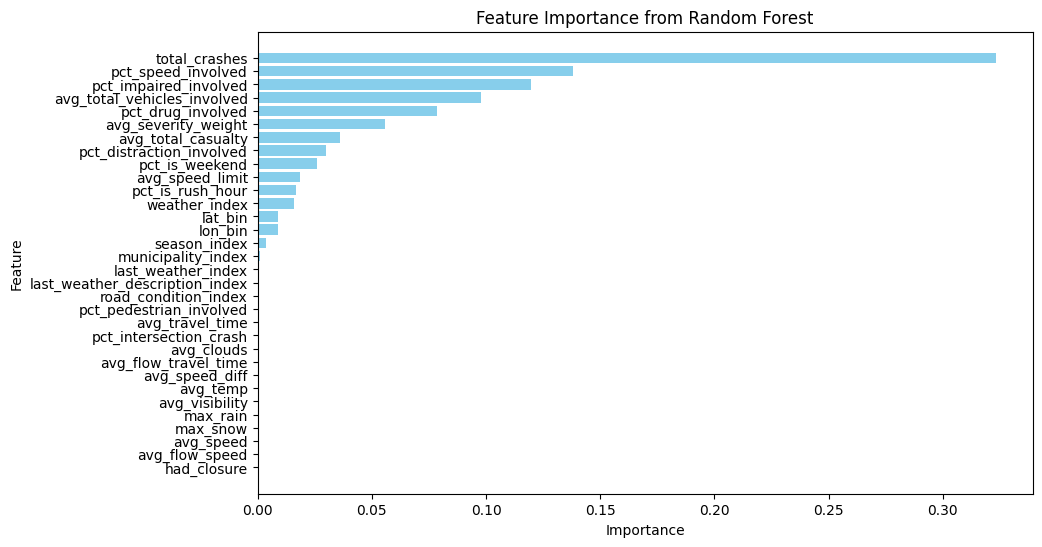

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Get the trained random forest model
rf_model = model.stages[-1]

# Get feature importances
feature_importances = rf_model.featureImportances

# Combine feature names with their importances
features = numerical_columns + [col + "_index" for col in categorical_columns]
feature_importance_dict = dict(zip(features, feature_importances))

# Sort the feature importance dictionary by importance (descending)
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print sorted feature importance values
print("Sorted Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

# Step 2: Plot the feature importances
# Extract feature names and their corresponding importance values
sorted_features = [item[0] for item in sorted_feature_importance]
sorted_importances = [item[1] for item in sorted_feature_importance]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show most important feature at the top
plt.show()

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a parameter grid for Random Forest
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

# K-fold Cross-validation
crossval = CrossValidator(estimator=pipeline, 
                          estimatorParamMaps=param_grid, 
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy"), 
                          numFolds=5)  # Use 5-fold cross-validation

# Fit the model
cv_model = crossval.fit(train_df)

# Evaluate the best model
best_model = cv_model.bestModel
predictions = cv_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Cross-validated Model Accuracy: {accuracy:.4f}")





25/04/05 22:37:18 WARN DAGScheduler: Broadcasting large task binary with size 1236.1 KiB
25/04/05 22:37:19 WARN DAGScheduler: Broadcasting large task binary with size 1643.6 KiB
25/04/05 22:37:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/04/05 22:37:20 WARN DAGScheduler: Broadcasting large task binary with size 1294.6 KiB
25/04/05 22:37:23 WARN DAGScheduler: Broadcasting large task binary with size 1221.0 KiB
25/04/05 22:37:23 WARN DAGScheduler: Broadcasting large task binary with size 1623.4 KiB
25/04/05 22:37:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/04/05 22:37:25 WARN DAGScheduler: Broadcasting large task binary with size 1291.2 KiB
25/04/05 22:37:27 WARN DAGScheduler: Broadcasting large task binary with size 1236.1 KiB
25/04/05 22:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1643.6 KiB
25/04/05 22:37:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/04/05 22:37:29 WARN DAGSche

Cross-validated Model Accuracy: 0.9887


In [43]:
cv_model.save("model/cv_model")

best_model.save("model/best_rfc_model")

25/04/05 23:37:59 WARN TaskSetManager: Stage 4723 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.
25/04/05 23:38:01 WARN TaskSetManager: Stage 4764 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.


In [37]:
# Optional: Show sample predictions
#predictions.select("lat_bin", "lon_bin", "municipality", "hotspot_risk_level", "prediction").show(50)

predictions.filter(col('hotspot_risk_level') == 'high').show()

25/04/05 23:15:01 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


+-------+--------+-----------+----+---------+---------+------------+--------------+-------------+--------------+-------------------+-------+---------------+------+--------------+------------+---------------------------+------------------+----------------------+-----------------------+------------------------+-----------------+---------------------+------------------+--------------+----------------+--------+--------------+----------+--------+--------+------------+------------------------+---------+--------------+---------------+--------------------+------------------+-----------+-------------------+------------------+------------------+-------------+------------+--------------------+------------------+------------------------------+-----+----------------+-------------+-------------+------------------+----------------+----------------------------+--------------------+--------------------+--------------------+----------+
|lat_bin| lon_bin|time_period|year|    month|      day|municipality|

In [ ]:
# Get feature importances
feature_importances = rf_model.featureImportances

# List of features with their importance
features_with_importance = list(zip(numerical_columns + [col + "_index" for col in categorical_columns], feature_importances))

# Sort the features by importance in descending order
sorted_features = sorted(features_with_importance, key=lambda x: x[1], reverse=True)

# Select top N important features (you can adjust N based on your needs)
top_n_features = [feature for feature, importance in sorted_features[:10]]  # For example, top 10 features

# Now, filter the data to include only the selected top features
assembler = VectorAssembler(inputCols=top_n_features, outputCol="features")

# Create a new pipeline with the selected features
pipeline = Pipeline(stages=indexers + [indexer_target, assembler, rf])

# Retrain the model
model_retrained = pipeline.fit(train_df)

# Make predictions
predictions_retrained = model_retrained.transform(test_df)

# Evaluate the retrained model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_retrained = evaluator.evaluate(predictions_retrained)
print(f"Retrained Model Accuracy: {accuracy_retrained:.4f}")


model_retrained.save("model/feature_importance_model")


Retrained Model Accuracy: 0.9812


In [44]:

model_retrained.save("model/feature_importance_model")

In [33]:
# Check the number of features
assembler_output = assembler.transform(train_df)
print(f"Number of features: {len(assembler_output.columns)}")

from pyspark.sql.functions import col

train_df = train_df.select([col(c).cast("double") for c in numerical_columns])

train_df.printSchema()

Number of features: 42
root
 |-- lat_bin: double (nullable = true)
 |-- lon_bin: double (nullable = true)
 |-- total_crashes: double (nullable = true)
 |-- avg_severity_weight: double (nullable = true)
 |-- avg_speed_limit: double (nullable = true)
 |-- avg_total_vehicles_involved: double (nullable = true)
 |-- avg_total_casualty: double (nullable = true)
 |-- pct_intersection_crash: double (nullable = true)
 |-- pct_pedestrian_involved: double (nullable = true)
 |-- pct_distraction_involved: double (nullable = true)
 |-- pct_drug_involved: double (nullable = true)
 |-- pct_impaired_involved: double (nullable = true)
 |-- pct_speed_involved: double (nullable = true)
 |-- pct_is_weekend: double (nullable = true)
 |-- pct_is_rush_hour: double (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- avg_visibility: double (nullable = true)
 |-- avg_clouds: double (nullable = true)
 |-- max_rain: double (nullable = true)
 |-- max_snow: double (nullable = true)
 |-- avg_speed: double 

In [39]:
print(train_df.columns)
print(test_df.columns)


['lat_bin', 'lon_bin', 'total_crashes', 'avg_severity_weight', 'avg_speed_limit', 'avg_total_vehicles_involved', 'avg_total_casualty', 'pct_intersection_crash', 'pct_pedestrian_involved', 'pct_distraction_involved', 'pct_drug_involved', 'pct_impaired_involved', 'pct_speed_involved', 'pct_is_weekend', 'pct_is_rush_hour', 'avg_temp', 'avg_visibility', 'avg_clouds', 'max_rain', 'max_snow', 'avg_speed', 'avg_flow_speed', 'avg_travel_time', 'avg_flow_travel_time', 'avg_speed_diff', 'had_closure']
['lat_bin', 'lon_bin', 'time_period', 'year', 'month', 'day', 'municipality', 'region', 'total_crashes', 'crash_severity', 'avg_severity_weight', 'weather', 'avg_speed_limit', 'season', 'road_condition', 'road_surface', 'avg_total_vehicles_involved', 'avg_total_casualty', 'pct_intersection_crash', 'pct_pedestrian_involved', 'pct_distraction_involved', 'pct_drug_involved', 'pct_impaired_involved', 'pct_speed_involved', 'pct_is_weekend', 'pct_is_rush_hour', 'avg_temp', 'avg_visibility', 'avg_clouds',

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Calculate the number of features after one-hot encoding
num_categorical_features = sum([len(df.select(col).distinct().rdd.flatMap(lambda x: x).collect()) for col in categorical_columns])

# Define the MLP architecture
layers = [len(numerical_columns) + num_categorical_features, 64, 42, 3]  # input, hidden layers, output (3 classes)


# Step 1: StringIndex all categorical columns (and the target)
categorical_columns = ['municipality', 'weather', 'season', 'road_condition', 'last_weather', 'last_weather_description']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='skip') for col in categorical_columns]

# Step 2: OneHotEncode all indexed categorical columns
encoder = OneHotEncoder(inputCols=[col + "_index" for col in categorical_columns], 
                        outputCols=[col + "_ohe" for col in categorical_columns])

# Step 3: StringIndex the target variable
indexer_target = StringIndexer(inputCol="hotspot_risk_level", outputCol="label", handleInvalid='skip')

# Step 4: Assemble all features into a single vector
numerical_columns = ['lat_bin', 'lon_bin', 'total_crashes', 'avg_severity_weight', 'avg_speed_limit', 'avg_total_vehicles_involved', 
                     'avg_total_casualty', 'pct_intersection_crash', 'pct_pedestrian_involved', 'pct_distraction_involved', 
                     'pct_drug_involved', 'pct_impaired_involved', 'pct_speed_involved', 'pct_is_weekend', 'pct_is_rush_hour', 
                     'avg_temp', 'avg_visibility', 'avg_clouds', 'max_rain', 'max_snow', 'avg_speed', 'avg_flow_speed', 
                     'avg_travel_time', 'avg_flow_travel_time', 'avg_speed_diff', 'had_closure']

feature_cols = numerical_columns + [col + "_ohe" for col in categorical_columns]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Step 1: Create the MLP Classifier
mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", maxIter=100, layers=layers, blockSize=128, seed=1234)


# Step 2: Create the pipeline for MLP
pipeline_mlp = Pipeline(stages=indexers + [indexer_target, assembler, mlp])

# Step 3: Train the MLP model
model_mlp = pipeline_mlp.fit(train_df)

# Step 4: Make predictions with the MLP model
predictions_mlp = model_mlp.transform(test_df)

# Step 5: Evaluate the model
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_mlp = evaluator_accuracy.evaluate(predictions_mlp)
print(f"MLP Model Accuracy: {accuracy_mlp:.4f}")

# Evaluate other metrics (precision, recall, F1-score)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score_mlp = evaluator_f1.evaluate(predictions_mlp)
print(f"MLP Model F1 Score: {f1_score_mlp:.4f}")

evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precision")
precision_mlp = evaluator_precision.evaluate(predictions_mlp)
print(f"MLP Model Precision: {precision_mlp:.4f}")

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recall")
recall_mlp = evaluator_recall.evaluate(predictions_mlp)
print(f"MLP Model Recall: {recall_mlp:.4f}")

# Step 6: Confusion Matrix (optional)
from pyspark.mllib.evaluation import MulticlassMetrics

# Extract prediction and label columns
prediction_and_labels_mlp = predictions_mlp.select("prediction", "label").rdd

# Create the confusion matrix
metrics_mlp = MulticlassMetrics(prediction_and_labels_mlp)

# Print confusion matrix
confusion_matrix_mlp = metrics_mlp.confusionMatrix()
print("MLP Confusion Matrix:")
print(confusion_matrix_mlp)


Py4JJavaError: An error occurred while calling o112903.fit.
: org.apache.spark.SparkException: Input column municipality does not exist.
	at org.apache.spark.ml.feature.StringIndexerBase.$anonfun$validateAndTransformSchema$2(StringIndexer.scala:128)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:293)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.flatMap(TraversableLike.scala:293)
	at scala.collection.TraversableLike.flatMap$(TraversableLike.scala:290)
	at scala.collection.mutable.ArrayOps$ofRef.flatMap(ArrayOps.scala:198)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema(StringIndexer.scala:123)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema$(StringIndexer.scala:115)
	at org.apache.spark.ml.feature.StringIndexer.validateAndTransformSchema(StringIndexer.scala:145)
	at org.apache.spark.ml.feature.StringIndexer.transformSchema(StringIndexer.scala:252)
	at org.apache.spark.ml.PipelineStage.transformSchema(Pipeline.scala:71)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:237)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:145)
	at jdk.internal.reflect.GeneratedMethodAccessor191.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


MODEL 1 : Random Forest

MODEL 2 : MLP

HEATMAP VISUALIZATION

In [ ]:
# Convert predictions to Pandas
heatmap_df = predictions.select("latitude", "longitude", "prediction").toPandas()

# Map predictions back to labels
label_map = {0.0: "Low", 1.0: "Moderate", 2.0: "High"}
heatmap_df["hotspot_label"] = heatmap_df["prediction"].map(label_map)

# Assign weight (optional: to enhance heatmap intensity)
risk_weight = {"Low": 1, "Moderate": 3, "High": 5}
heatmap_df["weight"] = heatmap_df["hotspot_label"].map(risk_weight)

In [ ]:
import folium
from folium.plugins import HeatMap

# Initialize map centered around average lat/lon
center_lat = heatmap_df["latitude"].mean()
center_lon = heatmap_df["longitude"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Prepare data: [lat, lon, weight]
heat_data = heatmap_df[["latitude", "longitude", "weight"]].values.tolist()

# Add heatmap layer
HeatMap(heat_data, radius=15, blur=10, max_zoom=13).add_to(m)

# Save and display
m.save("hotspot_heatmap.html")
m